<a href="https://colab.research.google.com/github/Kabongosalomon/Demo-Ranking-protein-protein-interfaces-using-GNN/blob/master/Ranking%20protein-protein%20interfaces%20using%20Graph%20Convolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo for ranking protein-protein interfaces using Graph Convolution

## Project setup

In [1]:
# Copying data and code from GitHub repository
!git clone https://github.com/withai/Demo-Ranking-protein-protein-interfaces-using-GNN.git
!mv Demo-Ranking-protein-protein-interfaces-using-GNN/* .
!rm -r Demo-Ranking-protein-protein-interfaces-using-GNN

Cloning into 'Demo-Ranking-protein-protein-interfaces-using-GNN'...
remote: Enumerating objects: 5116, done.
remote: Total 5116 (delta 0), reused 0 (delta 0), pack-reused 5116
Receiving objects: 100% (5116/5116), 825.15 MiB | 27.55 MiB/s, done.
Resolving deltas: 100% (4008/4008), done.
Checking out files: 100% (5015/5015), done.


## Import libraries

In [2]:
# Import PyTorch
import torch
import torch.backends.cudnn as cudnn
from torch.utils import data
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.init as init

# Import Neural Network layer
from nn import Dense

# Import utility functions
from dataset import Dataset
from sampler import CustomSampler
from train import train
from test import test

# Import libraries for graphing
import pandas as pd
import numpy as np
from graph import show_results
import matplotlib.pyplot as plt
%matplotlib inline



## Run computation on GPU or CPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## Define Graph Convolution layer

$$
h^{(l)}_i = \sigma \left(\mathbf{W}^{(l)}_c h^{(l-1)}_i +
    \frac{1}{|N_i^{(int)}|}\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij} \right.  \left. + \frac{1}{|N_i^{(prot)}|}\sum_{j \epsilon N_i^{(prot)}} \mathbf{W}^{(l)}_{prot} h^{(l-1)}_j \bigodot E_{ij} + b^{(l)} \vphantom{\frac{1}{|N_i^{(neigh)}|}}\right)
$$


where for the layer $l$,  

$\mathbf{W}^{(l)}_c$ is the weight matrix for learning representations w.r.t central node,

$\mathbf{W}^{(l)}_{int}$ and $\mathbf{W}^{(l)}_{prot}$ are the weight matrix for learning representations w.r.t the neighbor nodes in the interface graph and the protein graph respectively,

$b^{(l)}$ is the bias vector, 

$h^{(l)}_i$ is the hidden node embedding of node $i$,

$N_i^{(int)}$ is the number of atoms surrounding node $i$ in the interface graph, 

$N_i^{(prot)}$ is the number of atoms surrounding node $i$ in the protein graph, 

$\sigma$  is the activation function, and

$E_{ij}$ is the value in the edge matrix between node $i$ and node $j$.

### How does computing neighborhood signals look like in the code?

Let's compute neighborhood signals in the interface graph

$
\begin{align}
\frac{1}{|N_i^{(int)}|}\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij} 
\end{align}
$

**Define all the variables**

In [4]:
# node features: One-hot encoding of 11 different atom types
node_feat = torch.tensor([
                            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # atom 1
                            [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # atom 2
                            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], # atom 3
                            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # atom 4 
                        ]).type(torch.float)

# indices of neighbor atoms in interface graph
int_indices = torch.tensor([
                            [1, 2, -1],  # neighbors of atom 1
                            [0, -1, -1], # neighbors of atom 2
                            [1, -1, -1], # neighbors of atom 3
                            [-1, -1, -1] # neighbors of atom 4
                          ])

# edge weights of neighbor atoms in interface graph
int_edges = torch.tensor([
                            [0.9, 0.2, -1], # weights of neighbors of atom 1
                            [0.1, -1, -1],  # weights of neighbors of atom 2
                            [0.5, -1, -1],  # weights of neighbors of atom 3
                            [-1, -1, -1]    # weights of neighbors of atom 4
                        ])

# weight matrix
num_of_features = 11
filters = 16

w_int = torch.randn(num_of_features, filters)


**Step 1: Compute signals for all the nodes in the graph**

In [5]:
node_Wn_int = torch.matmul(node_feat, w_int)

print(node_Wn_int.shape)
print(node_Wn_int)

torch.Size([4, 16])
tensor([[ 2.3239,  0.4397,  1.5336, -0.0870,  1.4858,  1.0108, -0.4441,  1.3633,
          0.1705,  0.8078,  0.1426, -0.9014,  0.8385, -0.6375, -0.3299,  0.5141],
        [-0.1769,  0.0370, -1.5215, -0.6729,  0.7768, -0.7116,  1.1419, -0.5748,
         -0.1958,  0.8004,  1.2566, -0.4445, -0.3126,  1.4015, -0.9406,  0.1729],
        [-0.5156, -0.5575, -0.7002, -0.1588,  0.5325,  1.3170, -1.8414, -0.8167,
         -0.4322, -0.4619, -0.4439, -0.0044, -1.1878, -1.6583, -0.2055, -1.4007],
        [ 0.0142, -1.6340, -0.3109,  0.7897,  0.0727, -1.3134, -0.7052, -2.8387,
          0.8414, -0.2012, -1.1112,  0.0311, -0.7950,  1.5866, -1.2399,  0.5462]])


**Step 2: Find all the neighbors of atoms that are participating in the interface graph**

In [6]:
int_part = torch.unsqueeze(int_indices > -1, 2).type(torch.float)

print(int_part.shape)
print(int_part)

torch.Size([4, 3, 1])
tensor([[[1.],
         [1.],
         [0.]],

        [[1.],
         [0.],
         [0.]],

        [[1.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.]]])


**Step 3: For each atom find the number of neighbors participating in the graph**

In [7]:
no_of_neighs_int = torch.sum(int_indices > -1, 1).unsqueeze(1)

print(no_of_neighs_int.shape)
print(no_of_neighs_int)

torch.Size([4, 1])
tensor([[2],
        [1],
        [1],
        [0]])


**Step 4a: Make sure we don't divide by zeros**

In [8]:
no_of_neighs_int[no_of_neighs_int == 0] = 1

print(no_of_neighs_int.shape)
print(no_of_neighs_int)

torch.Size([4, 1])
tensor([[2],
        [1],
        [1],
        [1]])


**Step 4b: Expand the dimension of edge weights to allow scalar multiplication**

In [9]:
int_edges = torch.unsqueeze(int_edges, 2)

print(int_edges.shape)
print(int_edges)

torch.Size([4, 3, 1])
tensor([[[ 0.9000],
         [ 0.2000],
         [-1.0000]],

        [[ 0.1000],
         [-1.0000],
         [-1.0000]],

        [[ 0.5000],
         [-1.0000],
         [-1.0000]],

        [[-1.0000],
         [-1.0000],
         [-1.0000]]])


**Step 5: Compute neighbor signals of all the nodes in the interface graph**

Step 5a: Grab all the neighbors of interface atoms

In [10]:
Zn_inter_step = node_Wn_int[int_indices]

print(Zn_inter_step.shape)
print(Zn_inter_step)

torch.Size([4, 3, 16])
tensor([[[-0.1769,  0.0370, -1.5215, -0.6729,  0.7768, -0.7116,  1.1419,
          -0.5748, -0.1958,  0.8004,  1.2566, -0.4445, -0.3126,  1.4015,
          -0.9406,  0.1729],
         [-0.5156, -0.5575, -0.7002, -0.1588,  0.5325,  1.3170, -1.8414,
          -0.8167, -0.4322, -0.4619, -0.4439, -0.0044, -1.1878, -1.6583,
          -0.2055, -1.4007],
         [ 0.0142, -1.6340, -0.3109,  0.7897,  0.0727, -1.3134, -0.7052,
          -2.8387,  0.8414, -0.2012, -1.1112,  0.0311, -0.7950,  1.5866,
          -1.2399,  0.5462]],

        [[ 2.3239,  0.4397,  1.5336, -0.0870,  1.4858,  1.0108, -0.4441,
           1.3633,  0.1705,  0.8078,  0.1426, -0.9014,  0.8385, -0.6375,
          -0.3299,  0.5141],
         [ 0.0142, -1.6340, -0.3109,  0.7897,  0.0727, -1.3134, -0.7052,
          -2.8387,  0.8414, -0.2012, -1.1112,  0.0311, -0.7950,  1.5866,
          -1.2399,  0.5462],
         [ 0.0142, -1.6340, -0.3109,  0.7897,  0.0727, -1.3134, -0.7052,
          -2.8387,  0.8414,

Step 5b: Select all the participating neighbors

In [11]:
Zn_inter_step = node_Wn_int[int_indices] * int_part

print(Zn_inter_step.shape)
print(Zn_inter_step)

torch.Size([4, 3, 16])
tensor([[[-0.1769,  0.0370, -1.5215, -0.6729,  0.7768, -0.7116,  1.1419,
          -0.5748, -0.1958,  0.8004,  1.2566, -0.4445, -0.3126,  1.4015,
          -0.9406,  0.1729],
         [-0.5156, -0.5575, -0.7002, -0.1588,  0.5325,  1.3170, -1.8414,
          -0.8167, -0.4322, -0.4619, -0.4439, -0.0044, -1.1878, -1.6583,
          -0.2055, -1.4007],
         [ 0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
          -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000,
          -0.0000,  0.0000]],

        [[ 2.3239,  0.4397,  1.5336, -0.0870,  1.4858,  1.0108, -0.4441,
           1.3633,  0.1705,  0.8078,  0.1426, -0.9014,  0.8385, -0.6375,
          -0.3299,  0.5141],
         [ 0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
          -0.0000,  0.0000, -0.0000, -0.0000,  0.0000, -0.0000,  0.0000,
          -0.0000,  0.0000],
         [ 0.0000, -0.0000, -0.0000,  0.0000,  0.0000, -0.0000, -0.0000,
          -0.0000,  0.0000,

Step 5c: Scale each of the participating neighbor by its edge weight

$\mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij}$

In [12]:
Zn_inter_step = node_Wn_int[int_indices] * int_part * int_edges

print(Zn_inter_step.shape)
print(Zn_inter_step)

torch.Size([4, 3, 16])
tensor([[[-1.5925e-01,  3.3279e-02, -1.3694e+00, -6.0565e-01,  6.9913e-01,
          -6.4048e-01,  1.0277e+00, -5.1729e-01, -1.7620e-01,  7.2036e-01,
           1.1309e+00, -4.0004e-01, -2.8137e-01,  1.2614e+00, -8.4652e-01,
           1.5560e-01],
         [-1.0312e-01, -1.1151e-01, -1.4003e-01, -3.1762e-02,  1.0650e-01,
           2.6341e-01, -3.6827e-01, -1.6334e-01, -8.6445e-02, -9.2382e-02,
          -8.8785e-02, -8.8521e-04, -2.3755e-01, -3.3165e-01, -4.1102e-02,
          -2.8014e-01],
         [-0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
           0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
           0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
          -0.0000e+00]],

        [[ 2.3239e-01,  4.3966e-02,  1.5336e-01, -8.7044e-03,  1.4858e-01,
           1.0108e-01, -4.4415e-02,  1.3633e-01,  1.7045e-02,  8.0783e-02,
           1.4256e-02, -9.0138e-02,  8.3851e-02, -6.3753e-02, -3.2989e-02,
   

Step 5d: Sum all the neighbors of an atom

$\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij}$

In [13]:
Zn_inter_step = torch.sum(node_Wn_int[int_indices] * int_part * int_edges, 1)

print(Zn_inter_step.shape)
print(Zn_inter_step)

torch.Size([4, 16])
tensor([[-0.2624, -0.0782, -1.5094, -0.6374,  0.8056, -0.3771,  0.6594, -0.6806,
         -0.2626,  0.6280,  1.0422, -0.4009, -0.5189,  0.9297, -0.8876, -0.1245],
        [ 0.2324,  0.0440,  0.1534, -0.0087,  0.1486,  0.1011, -0.0444,  0.1363,
          0.0170,  0.0808,  0.0143, -0.0901,  0.0839, -0.0638, -0.0330,  0.0514],
        [-0.0885,  0.0185, -0.7608, -0.3365,  0.3884, -0.3558,  0.5709, -0.2874,
         -0.0979,  0.4002,  0.6283, -0.2222, -0.1563,  0.7008, -0.4703,  0.0864],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


Step 5e: Divide with the number of atoms in interface graph

$\frac{1}{|N_i^{(int)}|}\sum_{j \epsilon N_i^{(int)}} \mathbf{W}^{(l)}_{int} h^{(l-1)}_j \bigodot E_{ij} $

In [14]:
Zn_inter = torch.sum(node_Wn_int[int_indices] * int_part * int_edges, 1) / no_of_neighs_int

print(Zn_inter.shape)
print(Zn_inter)

torch.Size([4, 16])
tensor([[-0.1312, -0.0391, -0.7547, -0.3187,  0.4028, -0.1885,  0.3297, -0.3403,
         -0.1313,  0.3140,  0.5211, -0.2005, -0.2595,  0.4649, -0.4438, -0.0623],
        [ 0.2324,  0.0440,  0.1534, -0.0087,  0.1486,  0.1011, -0.0444,  0.1363,
          0.0170,  0.0808,  0.0143, -0.0901,  0.0839, -0.0638, -0.0330,  0.0514],
        [-0.0885,  0.0185, -0.7608, -0.3365,  0.3884, -0.3558,  0.5709, -0.2874,
         -0.0979,  0.4002,  0.6283, -0.2222, -0.1563,  0.7008, -0.4703,  0.0864],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


### GCN Layer code

In [15]:
class GCN_layer(nn.Module):

    def __init__(self, v_feats, filters, dropout=0.1, bias=True, trainable=True, **kwargs):

        super(GCN_layer, self).__init__()

        self.v_feats = v_feats
        self.filters = filters
        self.dropout= dropout
        self.bias = bias
        self.trainable = trainable
        
        use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda:0" if use_cuda else "cpu")
        
        # Define non-linear function
        self.non_lin = nn.LeakyReLU()

        # Initialize dropout
        self.drop_layer = nn.Dropout(p=self.dropout)
       
        # Initialize learnable parameters
        self.Wvc = nn.Parameter(
                    init.kaiming_uniform_(
                        torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                            .type(torch.float).to(self.device))  # (v_dims, filters)
        self.Wvn_int = nn.Parameter(
                        init.kaiming_uniform_(
                            torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                                .type(torch.float).to(self.device))  # (v_dims, filters)
        self.Wvn_prot = nn.Parameter(
                        init.kaiming_uniform_(
                            torch.randn(self.v_feats, self.filters, requires_grad=self.trainable))
                                .type(torch.float).to(self.device))  # (v_dims, filters)
        self.bv = nn.Parameter(
                        torch.zeros(self.filters, requires_grad=self.trainable)
                            .type(torch.float).to(self.device))
        
        
    def forward(self, x):

        node_feat, prot_indices, int_indices, prot_edges, int_edges = x

        # generate center node signals
        Zc = torch.matmul(node_feat, self.Wvc)  # (n_verts, filters)

        # create neighbor signals
        v_Wvn_int = torch.matmul(node_feat, self.Wvn_int)  # (n_verts, filters)
        v_Wvn_prot = torch.matmul(node_feat, self.Wvn_prot)  # (n_verts, filters)
        
        # Find participating neighbors of the interface and protein graph in Graph Convolution 
        int_part = torch.unsqueeze(int_indices > -1, 2).type(torch.float)
        prot_part = torch.unsqueeze(prot_indices > -1, 2).type(torch.float)

        # Find the number of neighbors per atom
        no_of_neighs_int = torch.sum(int_indices > -1, 1).unsqueeze(1).to(self.device).type(torch.float)
        no_of_neighs_prot = torch.sum(prot_indices > -1, 1).unsqueeze(1).to(self.device).type(torch.float)
        no_of_neighs_int[no_of_neighs_int == 0] = 1
        no_of_neighs_prot[no_of_neighs_prot == 0] = 1
        
        # Expand interface and neighborh edge matrices to allow scalar multiplication
        if(len(int_edges.size()) != 3):
            int_edges = torch.unsqueeze(int_edges, 2)
            prot_edges = torch.unsqueeze(prot_edges, 2)

        # Generate neighbor signals w.r.t the interface and protein graph
        Zn_inter = torch.sum(v_Wvn_int[int_indices] * int_part * int_edges, 1) / no_of_neighs_int
        Zn_prot = torch.sum(v_Wvn_prot[prot_indices] * prot_part * prot_edges, 1) / no_of_neighs_prot

        # Combine central and neighbor signals
        Z = Zc + Zn_inter + Zn_prot

        # Add bias
        if self.bias:
            Z += self.bv

        # Apply activation function
        h = self.non_lin(Z)

        # Apply dropout
        if self.dropout:
            h = self.drop_layer(h)


        return h, prot_indices, int_indices, prot_edges, int_edges

## Define Graph Neural network

In [16]:
class GNN(torch.nn.Module):
    """
        GCN + Sum unit pooling + L1-loss
    """
    def __init__(self):
        super(GNN, self).__init__()

        # Define neural network layers
        self.conv1 = GCN_layer(v_feats=11, filters=16, dropout=0.1)
        self.conv2 = GCN_layer(v_feats=16, filters=32, dropout=0.1)
        self.conv3 = GCN_layer(v_feats=32, filters=64, dropout=0.1)
        self.dense = Dense(in_dims=64, out_dims=1, nonlin="linear")

        # Define optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=0.01, weight_decay=0.0001)

    def forward(self, x):
        
        # GCN layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x[0]
        # each row of x is now a feature vector.

        # Graph pooling
        x = torch.sum(x, 0).view(1, -1)
        x = F.normalize(x)

        # Dense layer
        x = self.dense(x)
        x = torch.squeeze(x, 1)

        return x

    def loss(self, output, target, reduction='mean'):
        # Define loss function
        return F.l1_loss(output, target, reduction=reduction)

## Initialize Graph Neural Network

In [17]:
model = GNN().to(device)

## Initialize PyTorch data loader and data sampler

In [18]:
dataset_path = "data"

# Train dataset generator - training
train_dataset = Dataset(dataset_path, "train")

train_params = {'sampler': CustomSampler(batch_complexes = 2,
                                   decoys_per_complex = 50,
                                   dataset_path = dataset_path,
                                   dataset_cat = "train",
                                   random_sample = True),
          'num_workers': 0,
          'collate_fn' : lambda x: x[0]}
training_generator = data.DataLoader(train_dataset, **train_params)

# Train dataset generator - testing
train_params = {'sampler': CustomSampler(batch_complexes = 2,
                                   decoys_per_complex = 300,
                                   dataset_path = dataset_path,
                                   dataset_cat = "train",
                                   verbose=False),
          'num_workers': 0,
          'collate_fn' : lambda x: x[0]}
test_generator_train_set = data.DataLoader(train_dataset, **train_params)

# Test dataset generator
test_dataset = Dataset(dataset_path, "test")
test_params = {'sampler': CustomSampler(batch_complexes = 2,
                                   decoys_per_complex = 300,
                                   dataset_path = dataset_path,
                                   dataset_cat = "test"),
          'num_workers': 0,
          'collate_fn' : lambda x: x[0]}
test_generator_test_set = data.DataLoader(test_dataset, **test_params)

No. of train complexes: 3
No. of test complexes: 2


## Train model

In [19]:
epochs = 10
mini_batches_per_epoch = 30

loss = []

for epoch in range(0, epochs):
    
    loss_ = train(model, device, training_generator, model.optimizer, epoch, mini_batches_per_epoch)
    
    loss.append(loss_)
    
    print("Epoch " + str(epoch+1)+ " loss : " + str(loss_))
    

Epoch 1 loss : 1.75940603017807
Epoch 2 loss : 1.403956413269043
Epoch 3 loss : 0.24477334320545197
Epoch 4 loss : 0.2959727942943573
Epoch 5 loss : 0.12984321638941765
Epoch 6 loss : 0.091643787920475
Epoch 7 loss : 0.13552726432681084
Epoch 8 loss : 0.11148318462073803
Epoch 9 loss : 0.17923108488321304
Epoch 10 loss : 0.15387709438800812


## Plot loss function

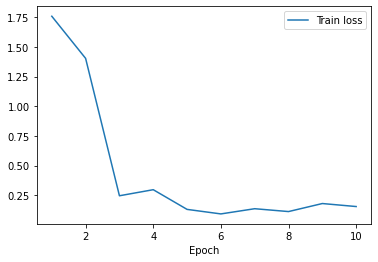

In [20]:
epoch_list = list(range(1, epochs+1))
epoch_losses = list(zip(epoch_list, loss))

loss_df = pd.DataFrame(epoch_losses, columns=["Epoch", "Train loss"])

lines = loss_df.plot.line(x="Epoch", y="Train loss")


## Test model

In [21]:
scores_dockq_train = test(model, device, test_generator_train_set, "train")
scores_dockq_test = test(model, device, test_generator_test_set, "test")

### Train complex 1 results

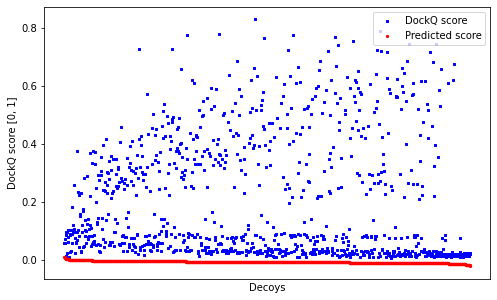

In [22]:
show_results("1bvn", scores_dockq_train)

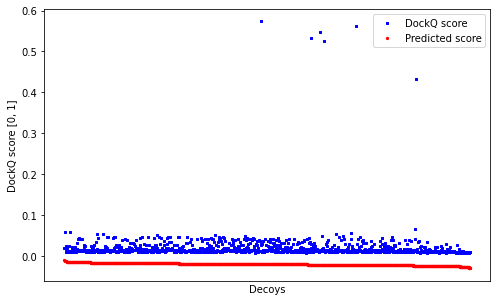

In [23]:
show_results("1f34", scores_dockq_train)

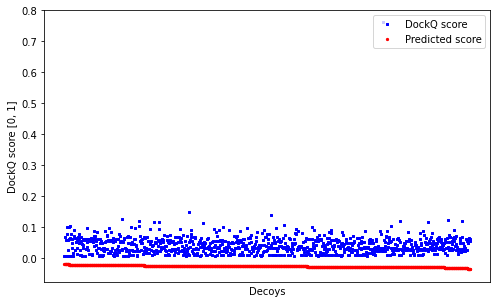

In [24]:
show_results("1pvh", scores_dockq_train)

### Test complex 1 results

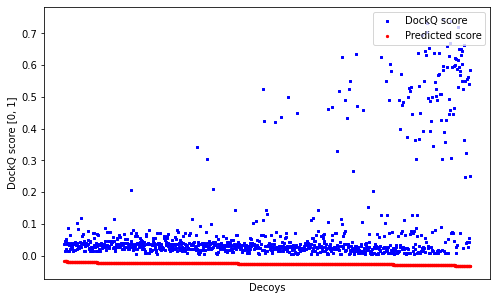

In [25]:
show_results("1b6c", scores_dockq_test)

### Test complex 2 results

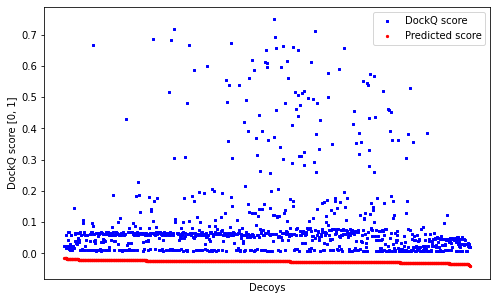

In [26]:
show_results("1e6e", scores_dockq_test)